In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from ql import QL, QLP
from dqn import DQN, DQNP
from cartpole import CartPole
from lunarlander import LunarLander
from search_params import space
from simulation import compute_scores
from viz import training_progress_static, param_decay

/Users/Stefan/.virtualenvs/rl/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
import os
from pathlib import Path
import json

In [4]:
from skopt import dummy_minimize
from skopt.utils import use_named_args

---

In [51]:
env = LunarLander()
agent = DQNP(env)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [52]:
default_config = agent.config
default_config

{'seed': 42,
 'lr_init': 0.005,
 'decay_freq': 200,
 'lr_decay': 0.1,
 'lr_min': 1e-05,
 'discount': 0.99,
 'history_len': 2,
 'idealization': 1,
 'policy': 'eps-greedy',
 'exploration_start': 1,
 'exploration_min': 0.01,
 'exploration_anneal_steps': 150,
 'exploration_temp': -1,
 'double': False,
 'target_update_freq': 0,
 'dueling': False,
 'streams_size': -1,
 'layer_sizes': (384, 192),
 'loss': 'mse',
 'hidden_activation': 'sigmoid',
 'out_activation': 'linear',
 'input_dropout': 0,
 'hidden_dropout': 0,
 'batch_normalization': False,
 'weights_init': 'lecun_uniform',
 'optimizer': 'adam',
 'q_clip': (-10000, 10000),
 'batch_size': 32,
 'n_epochs': 1,
 'memory_size': 50000,
 'min_mem_size': 1000,
 'normalize': False}

---

In [7]:
search_params = None

In [8]:
@use_named_args(space)
def f(**params):
    global search_params
    search_params = list(params.keys())
    return 0

In [9]:
_ = dummy_minimize(f, space, n_calls=1)

In [10]:
search_params

['exploration_start',
 'exploration_min',
 'exploration_anneal_steps',
 'exploration_temp',
 'lr_init',
 'lr_decay',
 'decay_freq',
 'idealization',
 'discount',
 'history_len',
 'target_update_freq',
 'batch_size',
 'n_epochs',
 'normalize',
 'input_dropout',
 'batch_normalization',
 'streams_size',
 'loss',
 'hidden_activation',
 'out_activation',
 'weights_init',
 'optimizer',
 'layer_sizes',
 'memory_size',
 'q_clip']

---

In [46]:
import re

In [47]:
from datetime import datetime

In [48]:
OUTPUTS_DIR = Path('outputs')
valid_names = [f for f in os.listdir(OUTPUTS_DIR)]
len(valid_names)

736

In [49]:
time_pattern = re.compile(r'^.*@ (?P<day>\d{2})\.(?P<month>\d{2}) (?P<hour>\d{2})\.(?P<minute>\d{2})')

In [53]:
%%time
dicts = []
for name in valid_names:
    lname = name.lower()
    for a in ['dqnp', 'dqn', 'qlp', 'ql']:
        if a in lname:
            ag = a
            break
    else:
        print(name, 'has no agent')
        continue
    
    for e in ['lander', 'pole']:
        if e in lname:
            en = e
            break
    else:
        print(name, 'has no env')
        continue
    
    match = time_pattern.search(name)
    date_args = {k: int(match.group(k)) for k in ['day', 'month', 'hour', 'minute']}
    
    run_dict = dict(
        filename=name,
        env=en,
        agent=ag,
        date=datetime(year=2018, **date_args),
    )
    run_dict.update(default_config)

    try:
        with open(OUTPUTS_DIR / name / 'agent.json') as f:
            run_dict.update(json.load(f))
    except:
        print(name, 'has no agent config')
        continue
#     if 'prioritize_replay' in run_dict:
#         continue    

    with open(OUTPUTS_DIR / name / 'stats.json') as f:
        run_dict.update(json.load(f))
#     if en == 'lander' and run_dict['time'] < 500:
#         print(name, 'only for testing')
#         continue

    train_df = pd.read_csv(OUTPUTS_DIR / name / 'train.csv')
    run_dict.update(compute_scores(
        train_df=train_df,
        eval_df=None,
    ))
    
    if train_df.episode.iloc[-1] < 20:
        print(name, 'only for testing')
        continue        
    
    dicts.append(run_dict)
    
    
print(len(dicts))

(0) DQNP on LunarLander @ 12.05 13.32 [272190051-21735583057792316264] only for testing
(0) DQNP on LunarLander @ 12.05 13.25 [-9223372036568121319-11785228619093306746] only for testing
(0) DQNP on LunarLander @ 12.05 13.30 [284982883-21735583057792316264] only for testing
(0) DQNP on LunarLander @ 12.05 13.52 [-9223372036562667502-11577897887892103550] only for testing
(0) DQNP on LunarLander @ 12.05 13.41 [274134904-21735583057792316264] only for testing
(0) DQNP on LunarLander @ 12.05 13.30 [-9223372036564186161-11785228619093306746] only for testing
(0) DQNP on LunarLander @ 12.05 13.37 [-9223372036575087763-21735583057792316264] only for testing
DQNP on LunarLander @ 10.05 14.13 [290411924] has no agent config
(0) DQNP on LunarLander @ 12.05 13.33 [290074730-13078852941665119073] only for testing
(0) DQNP on LunarLander @ 12.05 13.33 [-9223372036564684193-40434248734143184963] only for testing
(0) DQNP on LunarLander @ 12.05 13.27 [279251078-21735583057792316264] only for testing

In [54]:
df = pd.DataFrame(dicts)
df.head()

,agent,aggregated,anneal_steps,batch_normalization,batch_size,date,decay_freq,discount,double,dueling,...,priority_shift,q_clip,seed,solve_episode,streams_size,tail_avg,tail_std,target_update_freq,time,weights_init
0,dqnp,-218.917042,NaN,False,968,2018-05-13 00:06:00,196.0,0.686515,False,False,...,NaN,"[-10, 10]",7,NaN,-1,-223.158433,103.826950,60,1522.783010,lecun_uniform
1,dqnp,-82.019152,NaN,False,32,2018-05-11 19:10:00,200.0,0.990000,False,False,...,NaN,"[-10000, 10000]",9,NaN,-1,-101.064059,66.385600,0,2401.916211,lecun_uniform
2,dqnp,-208.775374,NaN,False,32,2018-05-13 14:40:00,242.0,0.947645,False,False,...,NaN,"[-1000, 1000]",0,NaN,-1,-197.021679,123.174629,0,1502.186097,random_uniform
3,dqnp,119.061006,NaN,False,32,2018-05-09 15:36:00,200.0,0.975000,False,False,...,NaN,"[-10000, 10000]",21,NaN,-1,98.225719,141.296341,0,2424.130786,lecun_uniform
4,dqnp,88.050374,NaN,False,32,2018-05-11 18:32:00,50.0,0.990000,False,False,...,NaN,"[-10000, 10000]",16,NaN,-1,120.399139,107.008470,0,1811.380615,lecun_uniform


In [55]:
df.to_csv('run_results.csv',index=False)

In [290]:
lander_bests = df[df.env == 'lander'].sort_values(by='aggregated', ascending=False)[['aggregated', 'tail_avg', 'tail_std', 'max_reward', 'final_reward', 'time', 'n_eps', 'solve_episode', 'filename', 'date']]
lander_bests.head(10)

,aggregated,tail_avg,tail_std,max_reward,final_reward,time,n_eps,solve_episode,filename,date
196,213.963854,207.991903,52.843462,261.681537,247.240793,1458.969640,400,400.0,DQNP on LunarLander @ 11.05 18.44 [8778192260949],2018-05-11 18:44:00
97,208.960646,204.231483,44.700087,260.359578,228.140566,1462.866963,400,NaN,DQNP on LunarLander @ 11.05 18.44 [-9223363258...,2018-05-11 18:44:00
154,206.907719,203.309484,35.406374,260.875604,212.524549,1760.055412,400,400.0,DQNP on LunarLander @ 11.05 18.08 [8767156824598],2018-05-11 18:08:00
484,203.634649,205.426291,37.758647,251.031701,188.250835,1800.202885,394,350.0,DQNP on LunarLander @ 11.05 17.15 [-9223363282...,2018-05-11 17:15:00
144,197.669233,209.398747,23.416850,261.744932,111.915758,1896.562695,400,NaN,DQNP on LunarLander @ 11.05 18.10 [8767042686440],2018-05-11 18:10:00
229,196.426025,198.687314,76.728735,259.251113,194.388679,1589.319492,400,NaN,dqn on lander @ 27.04 12.54-0,2018-04-27 12:54:00
591,194.995430,196.992128,46.235389,264.337524,169.607473,1476.907841,400,NaN,DQNP on LunarLander @ 11.05 17.09 [-9223363282...,2018-05-11 17:09:00
227,193.962522,186.789300,81.597704,254.889850,243.608882,1438.400170,400,400.0,DQNP on LunarLander @ 11.05 18.43 [-9223363258...,2018-05-11 18:43:00
149,191.301348,190.429380,63.974257,265.385748,188.921097,1282.005329,400,NaN,dqn on lander @ 27.04 09.34-3,2018-04-27 09:34:00
477,191.161103,180.953386,59.706244,256.682972,238.322604,1392.637721,400,NaN,dqn on lander @ 27.04 11.45-3,2018-04-27 11:45:00


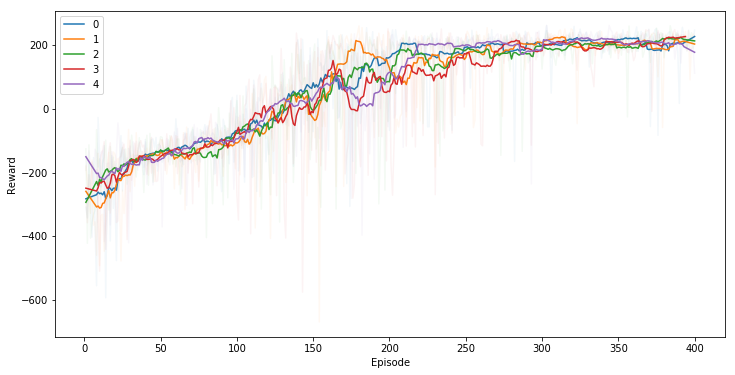

In [289]:
fnames = lander_bests.head(5).filename

names = list(range(len(fnames)))
dfs = [pd.read_csv(OUTPUTS_DIR / fname / 'train.csv') for fname in fnames] 
win_sizes = [15] * len(fnames)

plt.figure(figsize=(12, 6))
_ = training_progress_static(dfs, win_sizes, names)

In [ ]:
Stefanfname = 'DQNP on LunarLander @ 11.05 18.44 [8778192260949]'

In [93]:
Stefandf[df.env == 'pole'].sort_values(by='aggregated', ascending=False).iloc[0].filename

'QLP on CartPole @ 08.05 13.39 [-9223372036582720978]'

In [31]:
fname = 'QLP on CartPole @ 08.05 13.39 [-9223372036582720978]'
# fname = 'DQNP on LunarLander @ 11.05 18.44 [8778192260949]'  # 340
# fname = 'DQNP on LunarLander @ 11.05 18.10 [8767042686440]'  # 310
best_qlp_train = pd.read_csv(OUTPUTS_DIR / fname / 'train.csv')
best_qlp_evals = pd.read_csv(OUTPUTS_DIR / fname / 'evals.csv')
best_qlp_config = json.load(open(OUTPUTS_DIR / fname / 'agent.json'))

In [32]:
best_qlp_config

{'seed': 24,
 'init_mean': 0,
 'init_std': 0.1,
 'lr_init': 0.48227306094453914,
 'lr_decay': 0.19302684425393518,
 'decay_freq': 1000.0,
 'lr_min': 0.0001,
 'discount': 0.7441912616574788,
 'idealization': 0.12559847479756553,
 'exploration_start': 1.0,
 'exploration_min': 0.001,
 'anneal_steps': 300.0}

In [34]:
n_eps = best_qlp_train.episode.iloc[-1]
n_anneal = int(best_qlp_config['anneal_steps'])
# n_anneal = int(best_qlp_config['exploration_anneal_steps'])
max_val = best_qlp_config['exploration_start']
min_val = best_qlp_config['exploration_min']
expl_offset = 0
# expl_offset = 12

decr = (max_val - min_val) / n_anneal
expl = np.ones(n_eps) * max_val
expl[expl_offset : expl_offset + n_anneal] = max_val - np.arange(n_anneal) * decr
expl[expl_offset + n_anneal:] = min_val

In [15]:
best_qlp_train.steps.cumsum()

0          82
1         162
2         269
3         347
4         464
5         548
6         655
7         765
8         849
9         922
10       1020
11       1110
12       1185
13       1299
14       1385
15       1461
16       1567
17       1639
18       1749
19       1848
20       1952
21       2034
22       2119
23       2185
24       2255
25       2319
26       2407
27       2591
28       2653
29       2761
        ...  
370    133315
371    133564
372    133809
373    134057
374    134350
375    134619
376    134849
377    135379
378    135603
379    135851
380    136048
381    136299
382    136519
383    136777
384    136991
385    137240
386    137471
387    137734
388    137955
389    138125
390    138375
391    138635
392    138870
393    139223
394    139460
395    139748
396    139998
397    140277
398    140508
399    140830
Name: steps, Length: 400, dtype: int64

In [35]:
init_val = best_qlp_config['lr_init']
min_val = best_qlp_config['lr_min']
decay = best_qlp_config['lr_decay']
step_ep = int(best_qlp_config['decay_freq'])

lr = np.ones(n_eps) * init_val
lr[step_ep:] *= decay

In [36]:
def make_patch_spines_invisible(ax):
    """ https://matplotlib.org/gallery/ticks_and_spines/multiple_yaxis_with_spines.html """
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

In [307]:
(pd.rolling_mean(best_qlp_train.reward, window=100, min_periods=100) >= 200).tail(100)

/Users/Stefan/.virtualenvs/rl/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=100,min_periods=100,center=False).mean()
  """Entry point for launching an IPython kernel.


300    False
301    False
302    False
303    False
304    False
305    False
306    False
307    False
308    False
309    False
310     True
311     True
312     True
313     True
314     True
315     True
316     True
317     True
318     True
319     True
320     True
321     True
322     True
323     True
324     True
325     True
326     True
327     True
328     True
329     True
       ...  
370     True
371     True
372     True
373     True
374     True
375     True
376     True
377     True
378     True
379     True
380     True
381     True
382     True
383     True
384     True
385     True
386     True
387     True
388     True
389     True
390     True
391     True
392     True
393     True
394     True
395     True
396     True
397     True
398     True
399     True
Name: reward, Length: 100, dtype: bool

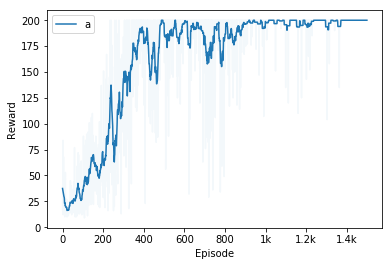

In [44]:
smoothed, = training_progress_static([best_qlp_train], [15], ['a'])

/Users/Stefan/.virtualenvs/rl/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


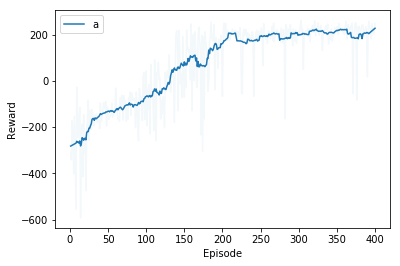

In [12]:
smoothed_reward, = training_progress_static([best_qlp_train], [15], ['a'])  # 340

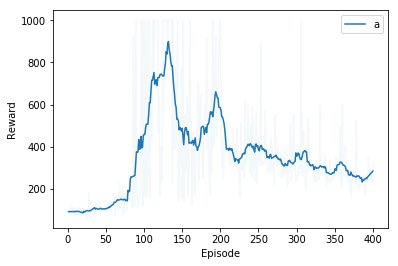

In [13]:
smoothed_steps, = training_progress_static([best_qlp_train], [15], ['a'], column='steps')  # 340

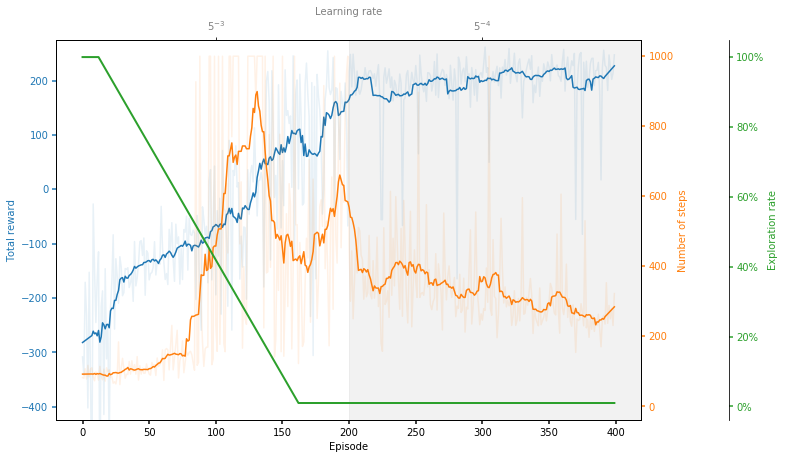

In [27]:
fig, host = plt.subplots(figsize=(13, 7))
fig.subplots_adjust(right=0.75)

par1 = host.twinx()
par2 = host.twinx()
ax2 = host.twiny()

# Offset the right spine of par2.  The ticks and label have already been
# placed on the right by twinx above.
par2.spines["right"].set_position(("axes", 1.15))
# Having been created by twinx, par2 has its frame off, so the line of its
# detached spine is invisible.  First, activate the frame but make the patch
# and spines invisible.
make_patch_spines_invisible(par2)
# Second, show the right spine.
par2.spines["right"].set_visible(True)

host.plot(best_qlp_train.reward, color='C0', alpha=.1)
p1, = host.plot(smoothed_reward, label='$\Sigma\ r$', color='C0')

par1.plot(best_qlp_train.steps, color='C1', alpha=.1)
p2, = par1.plot(smoothed_steps, color='C1')

p3, = par2.plot(expl, color='C2', linewidth=2)
par2.set_yticklabels(['{:.0%}'.format(y) for y in par2.get_yticks()])

# host.set_xlim(0, 2)
host.set_ylim(-425, 275)
par1.set_ylim(-40, par1.get_ylim()[1])
# par2.set_ylim(-.05, 1.05)
# par2.set_ylim(
#     par2.get_ylim()[0] -.001,
#     par2.get_ylim()[1] +.004
# )

prev_xlim = host.get_xlim()
host.axvspan(200, prev_xlim[1], alpha=0.1, color='grey')
host.set_xlim(*prev_xlim)

ax2.set_xticks([100, 300])
ax2.set_xlim(host.get_xlim())
ax2.set_xticklabels(['$5^{-3}$', '$5^{-4}$'], color='grey')
ax2.set_xlabel('Learning rate', color='grey')


host.set_xlabel('Episode')
host.set_ylabel('Total reward')
par1.set_ylabel('Number of steps')
par2.set_ylabel('Exploration rate')

host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())
par2.yaxis.label.set_color(p3.get_color())

tkw = dict(size=4, width=1.5)
host.tick_params(axis='y', colors=p1.get_color(), **tkw)
par1.tick_params(axis='y', colors=p2.get_color(), **tkw)
par2.tick_params(axis='y', colors=p3.get_color(), **tkw)
host.tick_params(axis='x', **tkw)

# lines = [p1, p2, p3]
# host.legend(lines, [l.get_label() for l in lines], loc=(.84, .25))

plt.savefig('figures/dqn-lander-params.png', dpi=200, bbox_inches='tight')
plt.show()

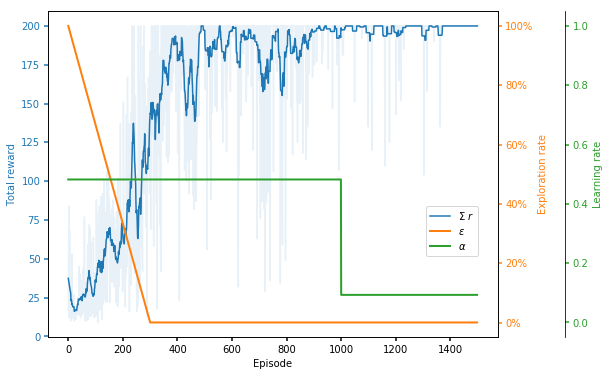

In [45]:
fig, host = plt.subplots(figsize=(10, 6))
fig.subplots_adjust(right=0.75)

par1 = host.twinx()
par2 = host.twinx()

# Offset the right spine of par2.  The ticks and label have already been
# placed on the right by twinx above.
par2.spines["right"].set_position(("axes", 1.15))
# Having been created by twinx, par2 has its frame off, so the line of its
# detached spine is invisible.  First, activate the frame but make the patch
# and spines invisible.
make_patch_spines_invisible(par2)
# Second, show the right spine.
par2.spines["right"].set_visible(True)

p1, = host.plot(best_qlp_train.reward, color='C0', alpha=.1)
p1, = host.plot(smoothed, label='$\Sigma\ r$', color='C0')
p2, = par1.plot(expl, label='$\epsilon$', color='C1', linewidth=2)
p3, = par2.plot(lr, label='$\\alpha$', color='C2', linewidth=2)

par1.set_yticklabels(['{:.0%}'.format(y) for y in par1.get_yticks()])

# host.set_xlim(0, 2)
# host.set_ylim(-425, 275)
# par1.set_ylim(-.05, 1.05)
par2.set_ylim(-.05, 1.05)

host.set_xlabel('Episode')
host.set_ylabel('Total reward')
par1.set_ylabel('Exploration rate')
par2.set_ylabel('Learning rate')

host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())
par2.yaxis.label.set_color(p3.get_color())

tkw = dict(size=4, width=1.5)
host.tick_params(axis='y', colors=p1.get_color(), **tkw)
par1.tick_params(axis='y', colors=p2.get_color(), **tkw)
par2.tick_params(axis='y', colors=p3.get_color(), **tkw)
host.tick_params(axis='x', **tkw)

lines = [p1, p2, p3]

host.legend(lines, [l.get_label() for l in lines], loc=(.84, .25))

plt.savefig('figures/ql-pole-params.png', dpi=200, bbox_inches='tight')
plt.show()

In [18]:
y = df.aggregated

In [56]:
x = df[search_params]

In [57]:
x.to_csv('prior-xs.csv', index=False)

In [58]:
y.to_csv('prior-ys.csv', index=False)

In [23]:
y.idxmax()

125

In [25]:
df.iloc[125]

aggregated                                                            213.964
batch_normalization                                                     False
batch_size                                                                 32
decay_freq                                                                200
discount                                                                 0.99
double                                                                  False
dueling                                                                 False
episodes                                                                  NaN
exploration                                                               NaN
exploration_anneal_steps                                                  150
exploration_min                                                          0.01
exploration_start                                                           1
exploration_temp                                                